# Comment tester le plus efficacement possible une population en cas d’épidémie ?


&nbsp;&nbsp;&nbsp;&nbsp; Pour notre projet de programmation, nous avons choisi de répondre à une question cruciale lors d’épidémies de grande ampleur, en nous interrogeant sur les **méthodes de dépistage qui permettraient d’utiliser le moins de tests possibles**. Le but est ainsi d’identifier les personnes contaminées, pour les isoler et empêcher la formation de nouveaux clusters.
Nous sommes partis du constat que les **méthodes de « pooling »** menées en Allemagne pour détecter les patients atteints du Covid-19 étaient très efficaces. Ces méthodes consistent à rassembler des échantillons de plusieurs individus dans un seul tube. Si le résultat de l'analyse du *pool* est positif, alors au moins un individu est contaminé, et les échantillons sont donc testés individuellement.


&nbsp;&nbsp;&nbsp;&nbsp;Nous avons mis en place **trois méthodes de « pooling »** : 
*   Le **pooling naïf**, qui consiste à regrouper les échantillons, les tester une première fois groupés, puis à les tester individuellement si le résultat est positif. 
*   Le **pooling en carré**, qui consiste à placer les échantillons de chaque individu dans une matrice, puis à tester chaque ligne et chaque colonne. Lorsque des pools sont positifs, on peut relier les informations et identifier la personne infectée, ou tester de nouveau s’il y a plusieurs lignes et colonnes positives. 
*   La **méthode par dichotomie**, qui consiste à diviser successivement par deux le groupe d'individus pour trouver les cas positifs.


&nbsp;&nbsp;&nbsp;&nbsp;Pour retranscrire nos résultats, nous avons choisi de présenter, pour une population donnée, le nombre de tests nécessaires pour chacune des trois méthodes, en fonction du taux de contamination. Globalement, on observe que la méthode naïve est moins efficace que les méthodes plus avancées, mais sa simplicité constitue un avantage pratique.


&nbsp;&nbsp;&nbsp;&nbsp;Un facteur clé à étudier pour mettre en pratique ces méthodes est la taille des pools choisie. En effet, regrouper les individus en pools de différentes tailles change grandement l'efficacité finale de la méthode. On peut donc s'intéresser à **la recherche de taille de pools optimales**, en fonction du taux d'infection. Intuitivement, on peut en effet voir que si une seule personne sur mille est touchée, rassembler les gens par pools de 2 sera très inefficace, et il vaudra mieux faire des pools plus grands. De même, si une personne sur 5 est touchée, faire des pools de 100 donne un résultat encore moins efficace que de tester tout le monde un à un.

En calculant ces tailles de pools optimales pour la méthode naïve, on extrait une loi mathématique reliant taux de contamination et taille de pool, qui aide grandement au calcul de ces tailles optimales. 


&nbsp;&nbsp;&nbsp;&nbsp;Pour affiner nos modèles, nous avons décidé de prendre en compte les clusters (groupes séparés plus ou moins contaminés) et les regroupements en famille, comme lors d’un confinement. 


*   **les clusters** : pour une méthode donnée (ici le pooling simple), nous avons comparé le nombre de tests nécessaires pour le cas où l’on sépare le cluster de la population générale et pour le cas où l’on mélange les individus des deux populations dans les échantillons constituants les pools. Le résultat de l’algorithme nous montre qu’il est toujours préférable de tester ces groupes de manière séparée, sans les mélanger dans les échantillons avec le reste de la population.
*   **les familles** : On suppose ici que les individus vivant ensemble ont de fortes chances de se transmettre le virus. Ainsi, adapter les méthodes de tests à cette hypothèse permet d'améliorer considérablement les performances des algorithmes de tests.


## Les importations


In [0]:
from math import floor, sqrt
import matplotlib.pyplot as plt
import numpy as np
import random as rd

## Quelques réglages en fonction des données sur l'épidémie

In [0]:
N = 10000 # nombre d'individus
p = 1e-2 # taux de contamination
tests = 0
gens = [rd.choices([0,1], [1-p, p])[0] for i in range(N)] # liste des individus

# I] Les trois principales méthodes de pooling

### 1) Le test par pooling naïf, ou pooling simple

Après avoir fait des groupes de Np individus, on teste l'echantillon du groupe entier pour savoir si au moins une personne est contaminée. Si c'est le cas, on teste individuellement chaque individu du groupe.

In [0]:
def simplepools(Np, p, gens=gens, N=N, tests=tests): # Np=taille des pools, p taux de contamination
    gens = [rd.choices([0,1], [1-p, p])[0] for i in range(N)]
    tests = 0
    N = len(gens)
    for i in range(N//Np):
        tests += 1
        if 1 in gens[Np*i:Np*(i+1)]: # on teste les Np individus rassemblés
            for i in range(Np*i, Np*(i+1)):
                tests += 1 # si pool positif, on les teste tous
    if N%Np != 0: # s'il reste des gens à la fin
        lasts = gens[Np*(N//Np):]
        tests += 1
        if len(lasts) > 1:
            if 1 in lasts: # on fait un pool avec tous ces gens
                tests += len(lasts)
    return(100*tests/len(gens)) # on renvoie le taux de tests par rapport à la taille de la population

res = round(simplepools(11, 0.01),2)
print(res)
print('Lecture : on peut tester 100 personnes en effectuant seulement {} tests en moyenne'.format(res))

20.32
Lecture : on peut tester 100 personnes en effectuant seulement 20.32 tests en moyenne


### 2) Le pooling en carré

![Schema carrés](https://i.imgur.com/MqXWJRc.png)

In [0]:
sq = 10

def testmat(gens=gens, sq=sq, tests=tests):# fonction qui traite une matrice sq*sq
    col = []
    lin = []
    for i in range(sq):
        tests += 1
        if 1 in gens[i]: # on teste toute la ligne
            lin.append(i)
    if lin != []: # on continue que si il y a au moins un cas positif
        for j in range(sq):
            if 1 in gens[:, j]: # on teste toute la colonne
                col.append(j)
    if len(lin) == 1 or len(col) == 1: # si une seule ligne positive, on peut conclure
        return(tests)
    else:
        possibles = []
        for i in lin:
            for j in col:
                possibles.append((i, j)) # on ajoute aux possibles les intersections
        for i in possibles:
            tests += 1 #on fait un test par intersection (les ? dans le schéma)
    return(tests)

def mat_to_list(i): # donner le numéro dans la liste d'un élément d'une matrice
    return(10*i[0]+i[1])

def squarepools(sq, p, N=N): # fonction qui traite toute la liste en appelant successivement testmat
    gens = [rd.choices([0,1], [1-p,p])[0] for i in range(N)]
    Np = sq**2 # sq la taille du coté, Np la taille du pool
    pools = int(N/Np)
    tests = 0
    for k in range(pools):
        square = np.reshape(gens[Np*k:Np*(k+1)], (sq,sq)) # on fait une matrice carré sq*sq
        t = testmat(square, sq)
        tests += t
    if N%Np != 0: # s'il reste des gens
        fin = gens[Np*pools:]
        testsfin = annexe(10, fin) # on utilise le pooling naïf sur la fin
        tests += testsfin
    return(100*tests/len(gens))

def annexe(Np, gens=gens): # Fonction annexe pour faire du pooling naïf dans les autres fonctions
    anntests = 0
    N = len(gens)
    for i in range(N//Np):
        anntests += 1
        if 1 in gens[Np*i:Np*(i+1)]: # on teste les Np individus rassemblés
            for i in range(Np*i,Np*(i+1)):
                anntests += 1 # si pool positif, on les teste tous
    if N%Np != 0: # s'il reste des gens à la fin
        lasts = gens[Np*(N//Np):]
        anntests += 1
        if len(lasts) > 1:
            if 1 in lasts: # on fait un pool avec tous ces gens
                anntests += len(lasts)
    return(anntests)

res = round(squarepools(10, 0.01), 2)
print(res)
print('Lecture : on peut tester 100 personnes en effectuant seulement {} tests en moyenne'.format(res))

11.0
Lecture : on peut tester 100 personnes en effectuant seulement 11.0 tests en moyenne


On observe que cette méthode est bien plus efficace que la dernière, permettant de diviser par presque 10 le nombre de tests nécessités.

### 3) Le pooling par dichotomie

![Schéma du fonctionnement du pooling par dichotomie](https://members.loria.fr/ADeleforge/wp-content/blogs.dir/192/files/sites/192/2020/04/pool-testing1-768x628.png)

Schéma du fonctionnement du pooling par dichotomie ( [source: Antoine Deleforge,  LORIA](https://members.loria.fr/ADeleforge/les-maths-du-group-testing-melanger-des-prelevements-pour-accelerer-la-detection-du-covid-19/) )

Remarque: On n'a pas besoin de tester le pool 5, car le pool 4 est négatif, on est ainsi sur que le/les cas positifs se trouvent dans le reste des échantillons.

In [0]:
def dichotest(gens): # test un pool de 2^k gens recursivement
    if len(gens) == 1 or max(gens) == 0:
        return(1)
    else:
        l = len(gens)
        if max(gens[:l//2]) == 0:
            return(dichotest(gens[l//2:]) + 1)
        else:
            return(dichotest(gens[l//2:]) + dichotest(gens[:l//2]) + 1)
        
def dichopools(k, p, N=N): # on appelle dichotest successivement, pools de 2**k gens, taux de contamination p
    Np = 2**k
    pools = N//2**k
    tests = 0
    gens = [rd.choices([0,1], [1-p,p])[0] for i in range(N)]
    for i in range(pools):
        tests += dichotest(gens[Np*i:Np*(i+1)])
    if N%(2**k) != 0: # Si la taille de la population n'est pas un multiple de Np, on traite la fin avec annexe
        fin = gens[Np*pools:]
        testsfin = annexe(10, fin)
        tests += testsfin
    return(100*tests/len(gens))

res = round(dichopools(6, 0.01),2)
print(res)
print('Lecture : on peut tester 100 personnes en effectuant seulement {} tests en moyenne'.format(res))

8.95
Lecture : on peut tester 100 personnes en effectuant seulement 8.95 tests en moyenne


On voit que le résultat est encore meilleur, avec yne efficacité plus que décuplée. Cependant, cette méthode est plus dure à appliquer en pratique. En effet, dans ce cas ci, elle nécessite de faire des pools de 64 personnes, ce qui ne permet pas toujours une détection de chaque cas, les échantillons individuels étant trop dilués.

# II] Les résultats des tests en graphique

### 1) Les résultats du pooling simple en fonction du taux de contamination et de la taille des pools

taille des pools: [2, 3, 5, 7, 11, 17, 25, 38, 57, 86, 129, 194, 291, 437, 656, 985, 1477, 2216, 3325, 4987, 7481, 11222]


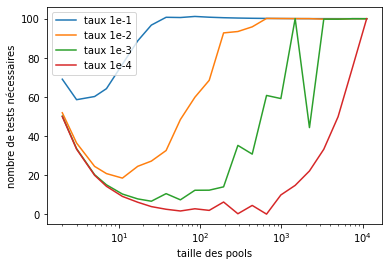

()

In [0]:
def efficacite_func(func): # Une fonction pour différents p et Np
    minpool = 2
    maxpool = 24
    pools = [int(1.5**Np) for Np in range(minpool, maxpool)] # echantillon de tailles de pools pour graphique semi-log
    ntest = []
    print('taille des pools:', pools)
    a=[]
    for p in range(4):
        ntest = []
        for Np in pools:
            ntest.append(func(Np, 10**(-p-1)))
        a.append(ntest)
    for i in range(4):
        plt.plot(pools, a[i], label = 'taux 1e-{}'.format(i+1))
    plt.xscale('log')
    plt.ylabel('nombre de tests nécessaires')
    plt.xlabel('taille des pools')
    plt.legend(loc = 'best')
    plt.show()
    return()

efficacite_func(simplepools)

Lecture : Pour un taux de contamination de 1%, en choisissant des pools de 11 personnes, on peut tester 100 personnes en environ 20 tests

### 2) Comparaison  sur  l'efficacité des différentes sorte de pooling en fonction de la taille des pools

Le nombre de tests mininimum pour simplepools est 20.0
Le nombre de tests mininimum pour squarepools est 8.8
Le nombre de tests mininimum pour dichopools est 10.74
taille des pools: [1, 2, 3, 5, 7, 10, 14, 20, 28, 40, 56, 79, 111, 155]


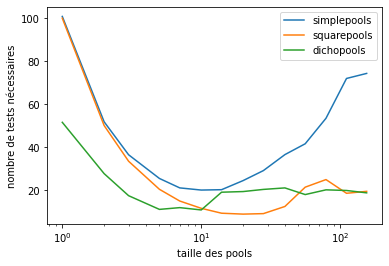

()

In [0]:
def comparer_funcs(p): # les trois fonctions pour un taux de contamination et (différentes tailles de pools)
    minpool = 2
    maxpool = 16
    pools = [int(1.4**Np) for Np in range(minpool, maxpool)]
    # pools=range(minpool,maxpool)
    ntest = []
    for func in [simplepools, squarepools, dichopools]:
        ntest = []
        for Np in pools:
            ntest.append(func(Np, p))
        plt.plot(pools, ntest, label = '{}'.format(func.__name__)) 
        print('Le nombre de tests mininimum pour ' + str(func.__name__) + ' est ' + str(round(min(ntest),2)))
    plt.xscale('log')
    plt.ylabel('nombre de tests nécessaires')
    plt.xlabel('taille des pools')
    plt.legend(loc = 'best')
    print('taille des pools:', pools)
    plt.show()
    return()

comparer_funcs(0.01)

Lecture: La fonction squarepools atteint une efficacité de 9% avec des pools de taille 16.

Remarque: la fonction dichopools atteint un plateau. En effet, quand Np est trop grand, on a $2^{Np} > N$, donc on ne peut pas faire de pool et toute la liste est traitée avec le pooling naïf, qui a une efficacité autour de 20%.

Le même phénomène est observé avec la fonction squarepools, mais pour des Np plus grands ($Np^2 > N$).

# III] Optimisation de la taille des pools pour la méthode naïve

Pour toutes les méthodes qui rassemblent un certains nombre d'individus, on a vu dans les graphiques que la taille de pool choisie influence grandement le résultat. C'est pourquoi il est utile de trouver, pour chaque fonction, et pour un taux de contamination donné, **la taille de pool optimale à utiliser en pratique.**

Pour trouver ce minimum, on utilise ici une méthode assez simple et peu efficace constistant à tester toutes les tailles de pools jusqu'à observer une efficacité qui diminue significativement. En effet, les courbes "*efficacité en fonction de Np*" sont initialement concave, avec une partie decroissante puis une partie croissante. Il est donc simple d'opérer en s'arrêtant une fois ce creux atteint. Pour être sûr d'avoir trouvé le minimum et non une section croissante simplement due à une coincidence, on continue un peu après le creux trouvé.

7
Lecture: Pour un taux de positifs de 2%, il faut choisir des pools de taille 2^7 pour utiliser la fonction simplepools optimalement


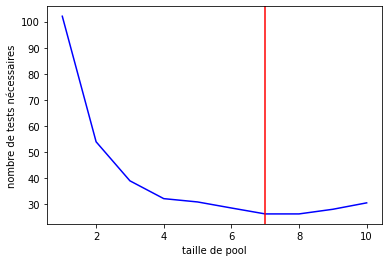

In [0]:
from math import inf

def optipool(p, func, graph = False): # trouve la meilleure taille de pool pour un taux p, func=dichopools, squarepools, simplepools
    mini = inf
    minp = 1
    courbe=[]
    for i in range(1,100): 
        s = func(i, p)
        courbe.append(s)
        if s < mini:
            mini = s
            minp = i
        if s > mini+2: # seuil de sensibilité
            if graph: #on affiche ou non la courbe, pour pouvoir réutiliser ça après
              plt.plot(range(1, len(courbe)+1), courbe, color='blue')
              plt.ylabel('nombre de tests nécessaires')
              plt.xlabel('taille de pool')
              plt.axvline(minp, color='red')
              plt.show
            return(minp)
    return(minp)
func=simplepools
a=optipool(0.02, func, True)
print(a)
print('Lecture: Pour un taux de positifs de 2%, il faut choisir des pools de taille 2^{} pour utiliser la fonction {} optimalement'.format(a,func.__name__))

Cette méthode n'est pas la plus efficace, mais elle trouve bien le minimum. Cependant, à cause de la nature aléatoire de la génération de la population, le résultat varie légèrement entre chaque calcul. On voit que ce n'est pas très grave, car la courbe est généralement assez plate autour du minimum, ce qui indique que même si l'on est pas exactement au minimum, on a à peu près la même efficacité.

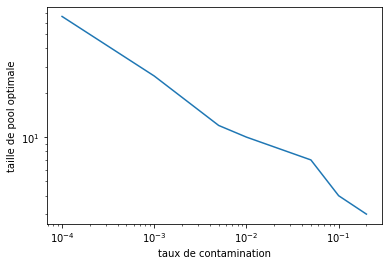

[3, 4, 7, 10, 12, 26, 66]

In [0]:
taux = [.2, .1, .05, .01, .005, .001, .0001] #on choisit un echantillon de taux
N=1000 # on prend un N petit car sinon la méthode est trop lente, mais on y perd en précision
def optigen(taux, func): # on calcule le Np optimal pour tous ces taux
    optis = []
    for p in taux:
        optis.append(optipool(p, func))
    return(optis)
op = optigen(taux,simplepools)
plt.yscale('log')
plt.xscale('log')
plt.plot(taux, op)
plt.ylabel('taille de pool optimale')
plt.xlabel('taux de contamination')
plt.show()

On observe une courbe quasi linéaire, ce qui suggère qu'il existerait une relation linéaire entre le log du Np optimal et le log du taux de contamination. De plus, la courbe varie considérablement entre les exécutions: cela vient des variations du Np optimal entre chaque exécution.

Comme la courbe est proche d'une droite, il est intéressant d'effectuer une régression linéaire sur ces données pour tenter de trouver une relation intrinsèque entre les tailles de pools optimales et le taux de contamination.



r**2 =  0.99738
p valeur =  1.195595538861953e-07


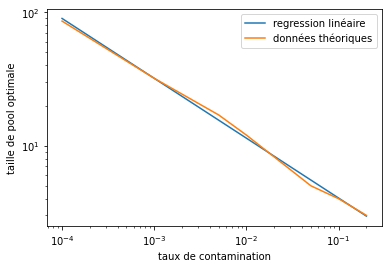

In [0]:
bonsNp = [3, 4, 5, 12, 17, 32, 86] # tailles obtenues avec N = 100 000
#On utilise ces données car elles sont plus précises que celles obtenues avec N=1000, ceci accélère le processus
from scipy.stats import linregress
from math import log, exp
tauxlog = [log(x) for x in taux]
Nplog = [log(y) for y in bonsNp]
slope, intercept, r_value, p_value, std_err = linregress(tauxlog, Nplog)
print('r**2 = ', round(r_value**2, 5))
print('p valeur = ', p_value)
x=np.linspace(1e-4, .2)
y=[exp(slope*log(i) + intercept) for i in x]
plt.plot(x, y, label = 'régression linéaire')
plt.plot(taux, bonsNp, label = 'données théoriques')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc = 'best')

plt.ylabel('taille de pool optimale')
plt.xlabel('taux de contamination')
plt.show()



On voit que la regression linéaire est extrêmement précise: on a un $r^2$ de 0,997, très proche de 1, et une p-valeur de $1.2*10^{-7}$, ce qui est quasi nul. Ainsi, ceci suggère qu'il existe en effet, pour le cas du pooling naïf, une relation mathématique linéaire entre le log du Np optimal et le log du taux de contamination.

Ces résultats peuvent donc être utilisés pour nous donner instantanément la taille de pool à utiliser en fonction du taux de positifs observé, avec la fonction suivante.



In [0]:
def pool_optimal(p):
  Np=exp(slope*log(p) + intercept)
  return(int(round(Np)))


print('taille de pool optimale pour un taux de contamination de 1%:', pool_optimal(.01))

taille de pool optimale pour un taux de contamination de 1%: 11


Test unitaire du succés de la regression linéaire

In [0]:
import unittest

class TestStringMethods(unittest.TestCase):

    def test_pool_optimal(self):
      self.assertEqual(pool_optimal(0.01), 11)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


# VI] Comment prendre en compte les clusters?

### Quelques réglages

In [0]:
N1 = 50000 # nombre d'individus du groupe 1 (= pop générale)
N2 = 1000 # nombre d'individus du groupe 2 (cluster)
N = N1 + N2 # pop totale
p1 = 0.01 # taux de contamination du groupe 1
p2 = 0.2 # taux de contamination du groupe 2
tests = 0
gens1 = [rd.choices([0,1], [1-p1,p1])[0] for i in range(N1)] # liste des gens du groupe 1
gens2 = [rd.choices([0,1], [1-p2,p2])[0] for i in range(N2)] # liste des gens du groupe 2
Np1 = pool_optimal(p1) # La taille des pools, obtenue avec la regression linéaire
Np2 = pool_optimal(p2)

### 1) Le pooling simple en mélangeant les individus des deux groupes

In [0]:
def melange_groupe (Np, gens1, gens2):
    gens = gens1 + gens2 
    rd.shuffle(gens) # mélange des deux populations
    tests = 0
    for i in range(N//Np):
        tests += 1
        if max(gens[Np*i:Np*(i+1)]) == 1: # on teste tous individus rassemblés dans les pools
            for i in range(Np*i, Np*(i+1)):
                tests += 1 # si pool positif, on les teste tous
    if N%Np != 0: # s'il reste des gens à la fin
        lasts = gens[Np*(N//Np):]
        tests += 1
        if len(lasts) > 1:
            if max(lasts) == 1: # on fait un pool avec tous ces gens
                tests += len(lasts)
    return(100*tests/len(gens))

res = round(melange_groupe(Np1, gens1, gens2),2)
print(res)
print('Lecture : on peut tester 100 personnes en effectuant seulement {} tests en moyenne'.format(res))

22.66
Lecture : on peut tester 100 personnes en effectuant seulement 22.66 tests en moyenne


### 2) Le pooling simple en séparant les individus de la population générale et des clusters

In [0]:
# Le nombre de tests pour la population générale :
def pop_gen(Np, p1, gens1, N1):
    tests = 0
    N = len(gens1)
    for i in range(N1//Np):
        tests += 1
        if max(gens1[Np*i:Np*(i+1)]) == 1: # on teste tous individus rassemblés
            for i in range(Np*i, Np*(i+1)):
                tests += 1 # si pool positif, on les teste tous
    if N%Np != 0: # s'il reste des gens à la fin
        lasts = gens1[Np*(N//Np):]
        tests += 1
        if len(lasts)>1:
            if max(lasts) == 1: # on fait un pool avec tous ces gens
                tests += len(lasts)
    return(tests)

# Le nombre de tests pour le cluster :
def clus(Np, p2, gens2, N2):
    tests = 0
    N = len(gens2)
    for i in range(N2//Np):
        tests += 1
        if max(gens2[Np*i:Np*(i+1)]) == 1: # on teste tous individus rassemblés
            for i in range(Np*i,Np*(i+1)):
                tests += 1 # si pool positif, on les teste tous
    if N%Np != 0: # s'il reste des gens à la fin
        lasts = gens2[Np*(N//Np):]
        tests += 1
        if len(lasts) > 1:
            if max(lasts) == 1: # on fait un pool avec tous ces gens
                tests += len(lasts)
    return(tests)

# Le nombre de test en tout
test_sep = pop_gen(Np1, p1, gens1, N1) + clus(Np2, p2, gens2, N2)
res = round((100*test_sep)/len(gens1+gens2),2)
print(res)
print('Lecture : on peut tester 100 personnes en effectuant seulement {} tests en moyenne'.format(res))

20.76
Lecture : on peut tester 100 personnes en effectuant seulement 20.76 tests en moyenne


### 3) Résultats de la comparaison

&nbsp;&nbsp;&nbsp;&nbsp;En effectuant plusieurs fois les deux programmes avec différents paramètres, on remarque qu'il est toujours préférable de tester les deux groupes séparément. 
La méthode séparée permet certes d'économiser des tests, mais la différence d'efficacité n'est pas très élevée, et  l'écart n'est en moyenne pas plus élevé que 3 points de pourcentage.

&nbsp;&nbsp;&nbsp;&nbsp;Ce résultat s'avère logique. En effet, en testant séparément, on peut utiliser des tailles de pools optimales pour chacune des populations, et avoir ainsi un meilleur résultat. 

# IV] Prendre en compte les familles dans la conception des pools de tests

Pour modéliser le fait que les individus sont confinés en groupes fixes, on procède de la manière suivante: on effectue des groupes de taille aléatoire variant entre 1 et 5 dans la population totale, et on distingue 2 types de familles (*cocons*): les cocons sains, où chaque individu a une probabilité *ps* faible d'être malade, et les cocons contaminés, où cette probabilité est *pc*, bien plus proche de 1. On fait l'hypothèse qu'une fois le virus entré dans un ménage, il se répand rapidement entre ses habitants.


### 1) Lister les familles

In [0]:
# quelques réglages
N = 100000 # nombre d'individus
ps = 0.01 # taux de contamination dans les concons sains
c = 0.02 # taux de cocons contaminés
s = 1-c
pc = 0.9 # taux de contamination dans les cocons contaminés
p = c*pc + s*ps # taux global
tests = 0
sq = 10
print('taux de contamination global:', round(p, 5))

taux de contamination global: 0.0278


Des fonctions annexes pour les listes de familles :


In [0]:
def infs(gens):
    return(sum([sum(i) for i in gens]))
def long(gens):
    return(sum([len(i) for i in gens]))

def taux(gens):
    return(infs(gens)/long(gens))

def bettermax(L): # cherche s'il y a un 1 dans une des sous listes
    a = True
    N = len(L)
    i = 0
    while a and i < N:
        if 1 in L[i]:
            return(True) # on s'arrête dès le premier cas trouvé
        i += 1
    return(False)

In [0]:
def cocons(N=N, ps=ps, pc=pc, c=c): # on génère la liste des familles
    g = 0
    gens = []
    while g < N:
        k = rd.randint(1,5) # familles de taille aléatoire entre 1 et 5
        g += k
        a = rd.choices([0,1], [1-c,c])[0] # décide si une famille est contaminée ou non
        if a == 1:
            cocon = rd.choices([0,1], [1-pc, pc], k=k)
        else:
            cocon = rd.choices([0,1], [1-ps, ps], k=k)
        gens.append(cocon)
    return(gens)

On teste la famille regroupée dans un seul *pool*, et si le résultat est positif, on teste tous les membres de la famille.

In [0]:
def coconpooling(N=N, ps=ps, pc=pc, c=c):
    gens = cocons(N, ps, pc, c)
    tests = 0
    for i in gens:
        tests += 1
        if 1 in i:
            if len(i) > 1:
                tests += len(i)
    return(100*tests/long(gens))

coconpooling()

38.419

On fait la même chose, mais en ayant rassemblé 3 familles avant

In [0]:
def cocongrouping(g, N=N, ps=ps, pc=pc, c=c):
    p = c*pc + s*ps
    gens = cocons(N, ps, pc, c)
    tests = 0
    f = len(gens)
    for i in range(f//g):
        tests += 1
        if bettermax(gens[g*i:g*(i+1)]):
            tests += long(gens[g*i:g*(i+1)])
    if f%g != 0:
        tests += 1
        if bettermax(gens[f//g*g:]):
            tests += long(gens[f//g*g:])
    return(100*tests/long(gens))

round(cocongrouping(3), 4)

25.736

### 2) Le square pooling adapté au familles

On effectue ici du square pooling en remplaçant les individus par des familles entières.

In [0]:
def testmatsquare(gens=gens, sq=sq, tests=tests):
    col = []
    lin = []
    for i in range(sq):
        tests += 1
        if bettermax(gens[i]): # on teste toute la ligne
            lin.append(i)
    if lin != []: # on continue que si y'a au moins un positif
        for j in range(sq):
            if bettermax(gens[:,j]): # on teste toute la colonne
                col.append(j)
    if len(lin) == 1: # si une seule ligne positive, on peut conclure
        a = lin[0]
        for j in col:
            tests += len(gens[a,j])
    elif len(col) == 1:# si une seule colonne positive, on peut conclure
        b = col[0]
        for i in lin:
            tests += len(gens[i,b])
    else:
        possibles = []
        for i in lin:
            for j in col:
                possibles.append((i,j))# on ajoute aux possibles les intersection
        for i in possibles:
            tests += len(i)
    return(tests)

def squarefam(sq, N=N):
    gens = cocons(N, ps, pc, c)
    N = len(gens)
    Np = sq**2 # sq la taille du coté, Np la taille du pool
    pools = int(N/Np)
    tests = 0
    for k in range(pools):
        square = np.reshape(gens[Np*k:Np*(k+1)], (sq,sq)) # on fait une matrice carré sq*sq
        t = testmatsquare(square, sq)
        tests += t
    if N%Np != 0: # s'il reste des gens
        fin = gens[Np*pools:]
        testsfin = coconpoolingannexe(fin, 10, p, fin) # on utilise l'annexe sur la fin
        tests += testsfin
    return(100*tests/long(gens))

def coconpoolingannexe(fin, N=N, ps=ps, pc=pc, c=c): # fonction annexe pour faire du coconpooling dans l'autre
    tests = 0
    for i in fin:
        tests += 1
        if 1 in i:
            if len(i)>1:
                tests += len(i)
    return(tests)

res = round(squarefam(5),2)
print(res)
print('Lecture : on peut tester 100 personnes en effectuant seulement {} tests en moyenne'.format(res))

13.03
Lecture : on peut tester 100 personnes en effectuant seulement 13.03 tests en moyenne


# Conclusion

&nbsp;&nbsp;&nbsp;&nbsp;En nous inspirant de la situation actuelle d’épidémie et des nouvelles problématiques qu’elle engendre, nous avons essayé de résoudre une question concrète en nous penchant sur les tests effectués. Nous avons montré qu’en mettant en place des méthodes de pooling et en utilisant les tailles de pools les plus adaptées possibles, le nombre de test pouvait être réduit. Ainsi, en adoptant la méthode la plus efficace, pour un taux de contamination et une taille de population donnés, toute la population peut être testée avec 10 fois moins de tests que si on testait chaque individu.

&nbsp;&nbsp;&nbsp;&nbsp;Ces méthodes ont cependant des limites techniques. Dans les faits, les pools ne peuvent rassembler plus d'environ 30 échantillons, selon la méthode de test choisie. En effet, si trop d’échantillons sont regroupés, le test n’est plus assez sensible et risque de ne pas détecter une personne infectée. De plus, la gestion de méthodes comme le pooling en carré ou la méthode par dichotomie peut, en pratique, être difficile à mener. Il faut que le laboratoire suive très précisément les trajectoires de chaque échantillon, et ces méthodes demandent beaucoup de manipulations. En effet, chaque échantillon peut être utilisé plusieurs fois et doit être conservé un certain temps.

&nbsp;&nbsp;&nbsp;&nbsp;Bien qu’elles ne soient pas parfaites, ces méthodes restent un atout dans la lutte contre les épidémies. Si ces méthodes étaient mises en place, elles permettraient de tester plus d’individus plus rapidement. A travers notre projet, nous voulions montrer que les débutants en programmation pouvaient être utiles, en évaluant virtuellement le nombre de tests nécessaires avant de l’appliquer aux individus.